# Trajectory Inference with VIA

VIA is a single-cell Trajectory Inference method that offers topology construction, pseudotimes, automated terminal state prediction and automated plotting of temporal gene dynamics along lineages. Here, we have improved the original author's colouring logic and user habits so that users can use the anndata object directly for analysis。 

We have completed this tutorial using the analysis provided by the original VIA authors.

Paper: [Generalized and scalable trajectory inference in single-cell omics data with VIA](https://www.nature.com/articles/s41467-021-25773-3)

Code: https://github.com/ShobiStassen/VIA

Colab_Reproducibility：https://colab.research.google.com/drive/1A2X23z_RLJaYLbXaiCbZa-fjNbuGACrD?usp=sharing

In [1]:
import omicverse as ov
import scanpy as sc
import matplotlib.pyplot as plt
ov.utils.ov_plot_set()

/Users/fernandozeng/miniforge3/envs/scbasset/lib/python3.8/site-packages/phate/__init__.py


## Data loading and preprocessing

We have used the dataset scRNA_hematopoiesis provided by the authors for this analysis, noting that the data have been normalized and logarithmicized but not scaled.

In [2]:
adata = ov.single.scRNA_hematopoiesis()
sc.tl.pca(adata, svd_solver='arpack', n_comps=200)
adata

computing PCA
    with n_comps=200
    finished (0:00:14)


AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'label'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'pca'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_pca'
    varm: 'PCs'

## Model construct and run

We need to specify the cell feature vector `adata_key` used for VIA inference, which can be X_pca, X_scVI or X_glue, depending on the purpose of your analysis, here we use X_pca directly. We also need to specify how many components to be used, the components should not larger than the length of vector.

Besides, we need to specify the `clusters` to be colored and calculate for VIA. If the `root_user` is None, it will be calculated the root cell automatically.

We need to set `basis` argument stored in `adata.obsm`. An example setting `tsne` because it stored in `obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_pca'`

We also need to set `clusters` argument stored in `adata.obs`. It means the celltype key.

Other explaination of argument and attributes could be found at https://pyvia.readthedocs.io/en/latest/Parameters%20and%20Attributes.html

In [3]:
v0 = ov.single.pyVIA(adata=adata,adata_key='X_pca',adata_ncomps=80, basis='tsne',
                         clusters='label',knn=30,random_seed=4,root_user=[4823],)

v0.run()

2023-04-08 16:07:56.457694	Running VIA over input data of 5780 (samples) x 80 (features)
2023-04-08 16:07:56.457759	Knngraph has 30 neighbors
2023-04-08 16:07:59.563166	Finished global pruning of 30-knn graph used for clustering at level of 0.15. Kept 46.3 % of edges. 
2023-04-08 16:07:59.580468	Number of connected components used for clustergraph  is 1
2023-04-08 16:07:59.757457	Commencing community detection
2023-04-08 16:07:59.825471	Finished running Leiden algorithm. Found 207 clusters.
2023-04-08 16:07:59.826890	Merging 189 very small clusters (<10)
2023-04-08 16:07:59.828542	Finished detecting communities. Found 18 communities
2023-04-08 16:07:59.828767	Making cluster graph. Global cluster graph pruning level: 0.15
2023-04-08 16:07:59.839755	Graph has 1 connected components before pruning
2023-04-08 16:07:59.840584	Graph has 2 connected components after pruning
2023-04-08 16:07:59.841028	Graph has 1 connected components after reconnecting
2023-04-08 16:07:59.841242	0.0% links tri

## Visualize and analysis

Before the subsequent analysis, we need to specify the colour of each cluster. Here we use sc.pl.embedding to automatically colour each cluster, if you need to specify your own colours, specify the palette parameter

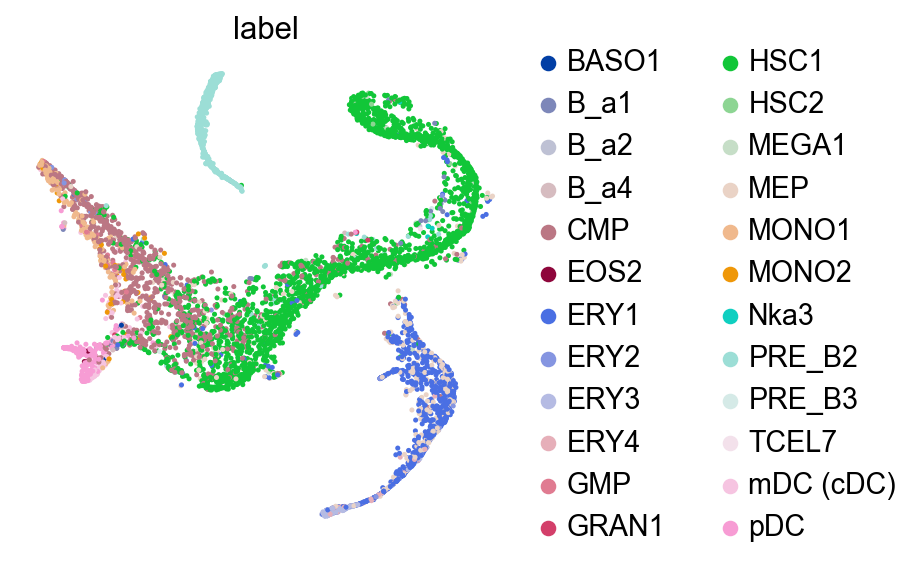

In [4]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
sc.pl.embedding(
    adata,
    basis="tsne",
    color=['label'],
    frameon=False,
    ncols=1,
    wspace=0.5,
    show=False,
    ax=ax
)
fig.savefig('figures/via_fig1.png',dpi=300,bbox_inches = 'tight')

## VIA graph

To visualize the results of the Trajectory inference in various ways. Via offers various plotting functions.We first show the cluster-graph level trajectory abstraction consisting of two subplots colored by annotated (true_label) composition and by pseudotime

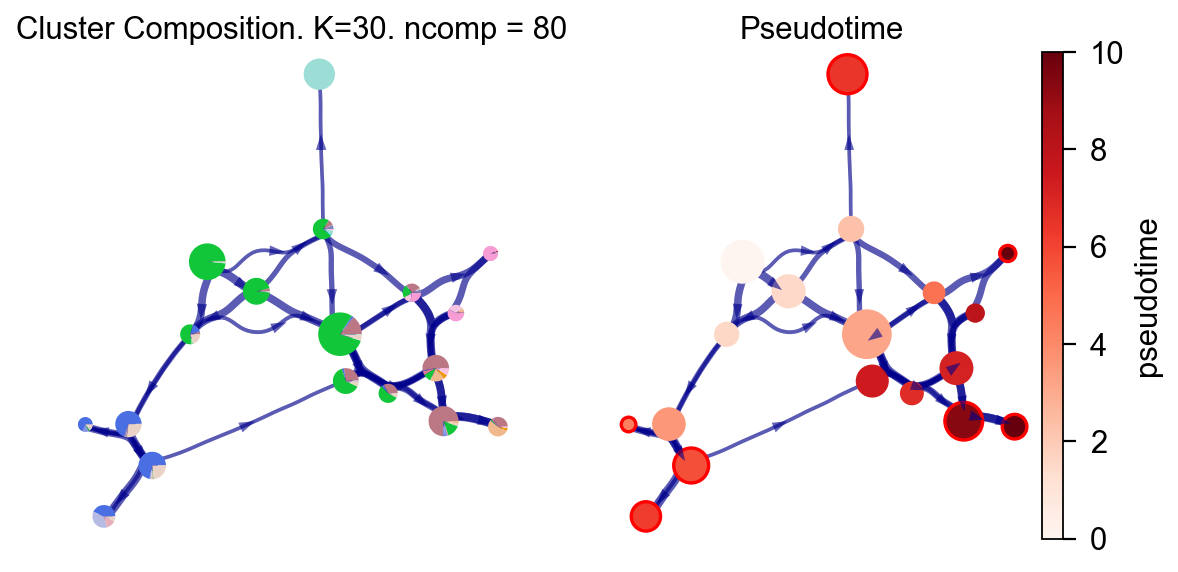

In [5]:
fig, ax, ax1 = v0.plot_piechart_graph(clusters='label',cmap='Reds',dpi=80,
                                   show_legend=False,ax_text=False,fontsize=4)
fig.savefig('figures/via_fig2.png',dpi=300,bbox_inches = 'tight')

In [ ]:
#you can use `v0.model.single_cell_pt_markov` to extract the pseudotime
v0.get_pseudotime(v0.adata)
v0.adata

## Visualise gene/feature graph

View the gene expression along the VIA graph. We use the computed HNSW small world graph in VIA to accelerate the gene imputation calculations (using similar approach to MAGIC) as follows: 


shape of transition matrix raised to power 3 (5780, 5780)


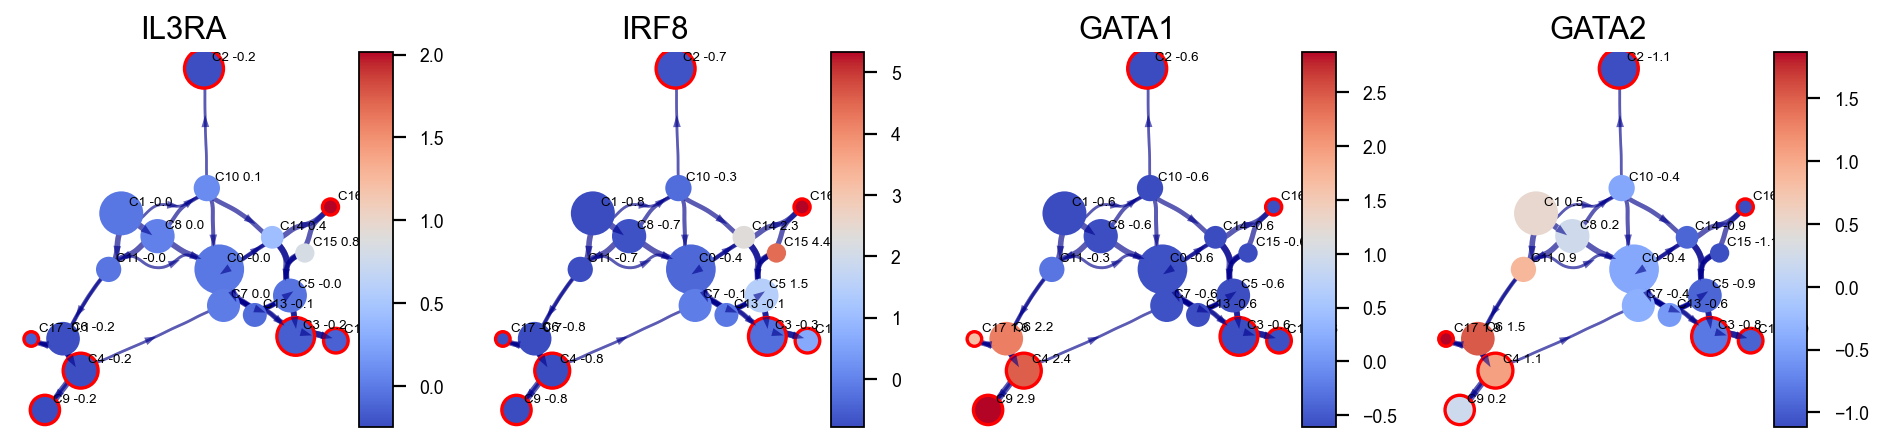

In [6]:
gene_list_magic = ['IL3RA', 'IRF8', 'GATA1', 'GATA2', 'ITGA2B', 'MPO', 'CD79B', 'SPI1', 'CD34', 'CSF1R', 'ITGAX']
fig,axs=v0.plot_clustergraph(gene_list=gene_list_magic[:4],figsize=(12,3),)
fig.savefig('figures/via_fig2_1.png',dpi=300,bbox_inches = 'tight')

## Trajectory projection

Visualize the overall VIA trajectory projected onto a 2D embedding (UMAP, Phate, TSNE etc) in different ways.

- Draw the high-level clustergraph abstraction onto the embedding;
- Draws a vector field plot of the more fine-grained directionality of cells along the trajectory projected onto an embedding.
- Draw high-edge resolution directed graph

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |#######################

2023-04-08 16:10:39.152008	Super cluster 2 is a super terminal with sub_terminal cluster 2
2023-04-08 16:10:39.152033	Super cluster 3 is a super terminal with sub_terminal cluster 3
2023-04-08 16:10:39.152038	Super cluster 4 is a super terminal with sub_terminal cluster 4
2023-04-08 16:10:39.152045	Super cluster 9 is a super terminal with sub_terminal cluster 9
2023-04-08 16:10:39.152050	Super cluster 12 is a super terminal with sub_terminal cluster 12
2023-04-08 16:10:39.152056	Super cluster 16 is a super terminal with sub_terminal cluster 16
2023-04-08 16:10:39.152061	Super cluster 17 is a super terminal with sub_terminal cluster 17


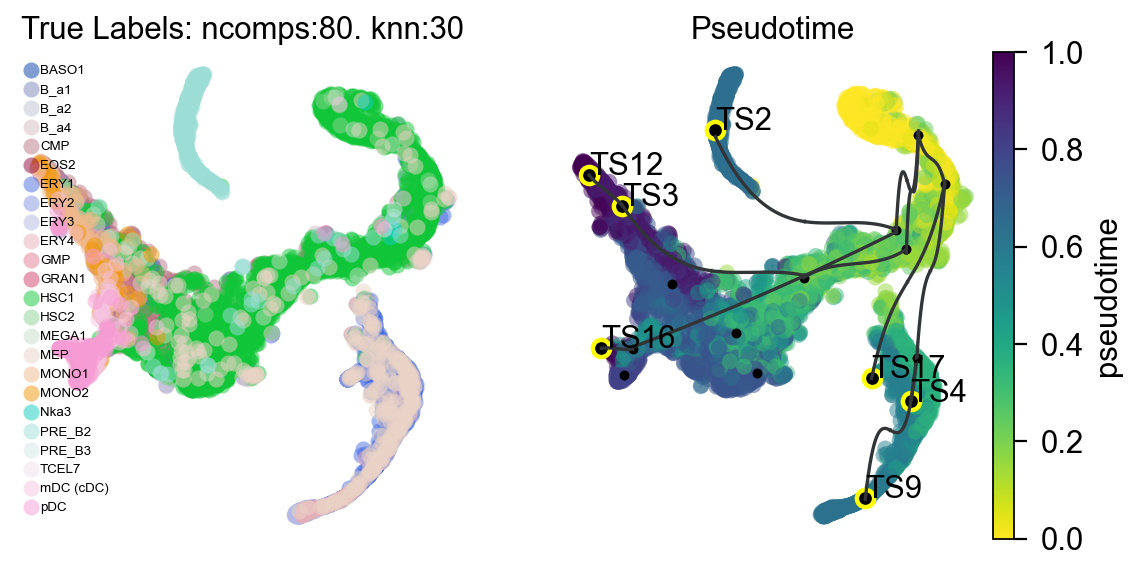

In [7]:
fig,ax1,ax2=v0.plot_trajectory_gams(basis='tsne',clusters='label',draw_all_curves=False)
fig.savefig('figures/via_fig3.png',dpi=300,bbox_inches = 'tight')

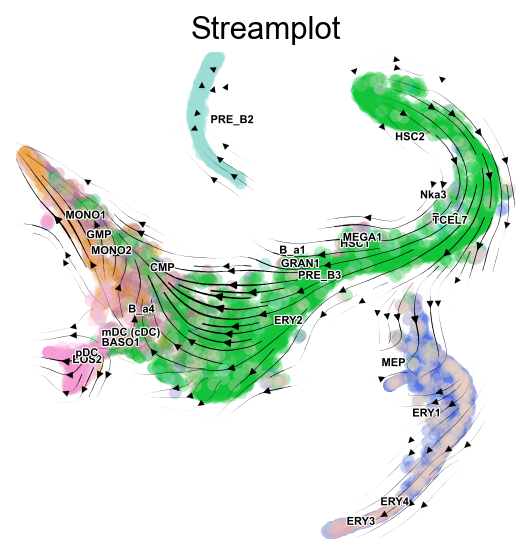

In [8]:
fig,ax=v0.plot_stream(basis='tsne',clusters='label',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
fig.savefig('figures/via_fig4.png',dpi=300,bbox_inches = 'tight')

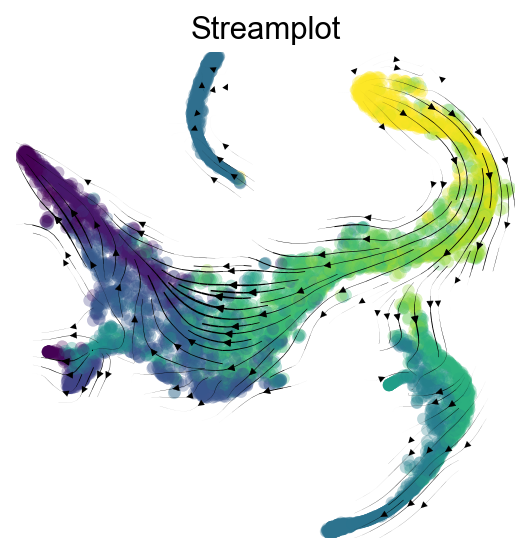

In [9]:
fig,ax=v0.plot_stream(basis='tsne',density_grid=0.8, scatter_size=30, color_scheme='time', linewidth=0.5,
                             min_mass = 1, cutoff_perc = 5, scatter_alpha=0.3, marker_edgewidth=0.1,
                             density_stream = 2, smooth_transition=1, smooth_grid=0.5)
fig.savefig('figures/via_fig5.png',dpi=300,bbox_inches = 'tight')

## Probabilistic pathways

Visualize the probabilistic pathways from root to terminal state as indicated by the lineage likelihood. The higher the linage likelihood, the greater the potential of that particular cell to differentiate towards the terminal state of interest.

2023-04-08 16:10:43.368902	Marker_lineages: [2, 3, 4, 9, 12, 16, 17]
2023-04-08 16:10:43.370404	The number of components in the original full graph is 1
2023-04-08 16:10:43.370414	For downstream visualization purposes we are also constructing a low knn-graph 
2023-04-08 16:10:47.249552	Check sc pb [0.    0.    0.317 0.302 0.013 0.109 0.26 ]
2023-04-08 16:10:47.385340	Cluster path on clustergraph starting from Root Cluster 1 to Terminal Cluster 2: [1, 8, 0, 10, 2]
2023-04-08 16:10:47.385368	Cluster path on clustergraph starting from Root Cluster 1 to Terminal Cluster 3: [1, 8, 0, 3]
2023-04-08 16:10:47.385374	Cluster path on clustergraph starting from Root Cluster 1 to Terminal Cluster 4: [1, 11, 6, 4]
2023-04-08 16:10:47.385379	Cluster path on clustergraph starting from Root Cluster 1 to Terminal Cluster 9: [1, 11, 6, 4, 9]
2023-04-08 16:10:47.385383	Cluster path on clustergraph starting from Root Cluster 1 to Terminal Cluster 12: [1, 8, 0, 3, 12]
2023-04-08 16:10:47.385388	Cluster pat

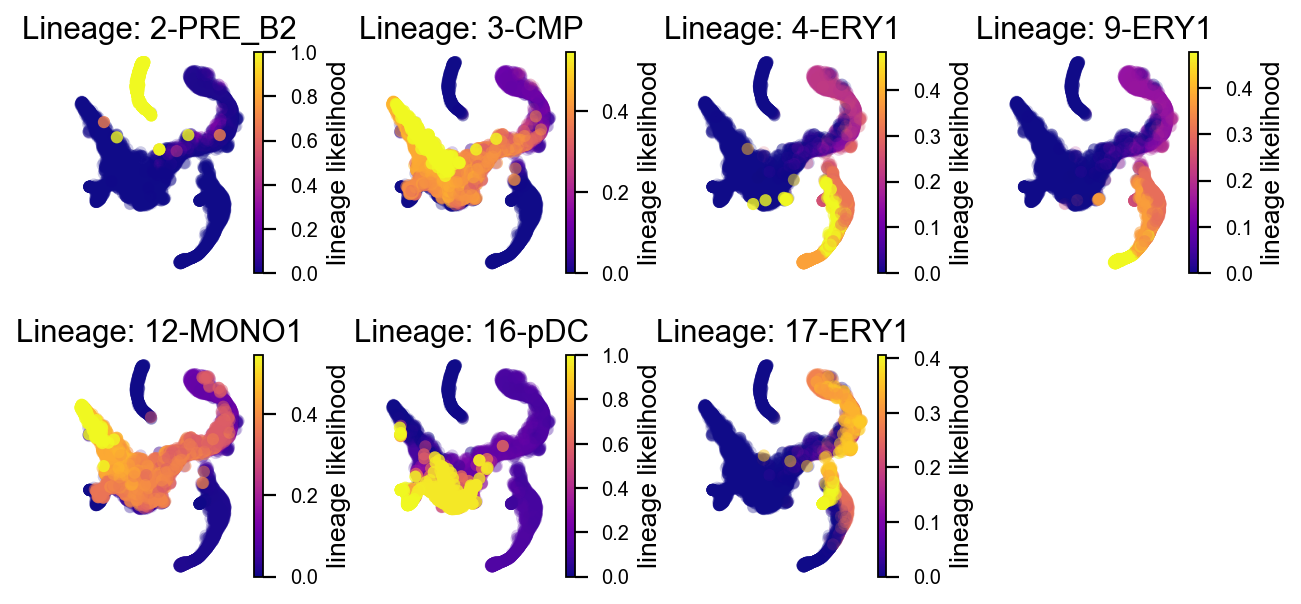

In [10]:
fig,axs=v0.plot_lineage_probability(figsize=(8,4),)
fig.savefig('figures/via_fig6.png',dpi=300,bbox_inches = 'tight')

We can specify a specific linkage for visualisation

2023-04-08 16:10:48.686467	Marker_lineages: [2, 3]
2023-04-08 16:10:48.688360	The number of components in the original full graph is 1
2023-04-08 16:10:48.688371	For downstream visualization purposes we are also constructing a low knn-graph 
2023-04-08 16:10:52.579451	Check sc pb [0.    0.    0.317 0.302 0.013 0.109 0.26 ]
2023-04-08 16:10:52.711032	Cluster path on clustergraph starting from Root Cluster 1 to Terminal Cluster 2: [1, 8, 0, 10, 2]
2023-04-08 16:10:52.711056	Cluster path on clustergraph starting from Root Cluster 1 to Terminal Cluster 3: [1, 8, 0, 3]
2023-04-08 16:10:52.711062	Cluster path on clustergraph starting from Root Cluster 1 to Terminal Cluster 4: [1, 11, 6, 4]
2023-04-08 16:10:52.711067	Cluster path on clustergraph starting from Root Cluster 1 to Terminal Cluster 9: [1, 11, 6, 4, 9]
2023-04-08 16:10:52.711071	Cluster path on clustergraph starting from Root Cluster 1 to Terminal Cluster 12: [1, 8, 0, 3, 12]
2023-04-08 16:10:52.711075	Cluster path on clustergraph 

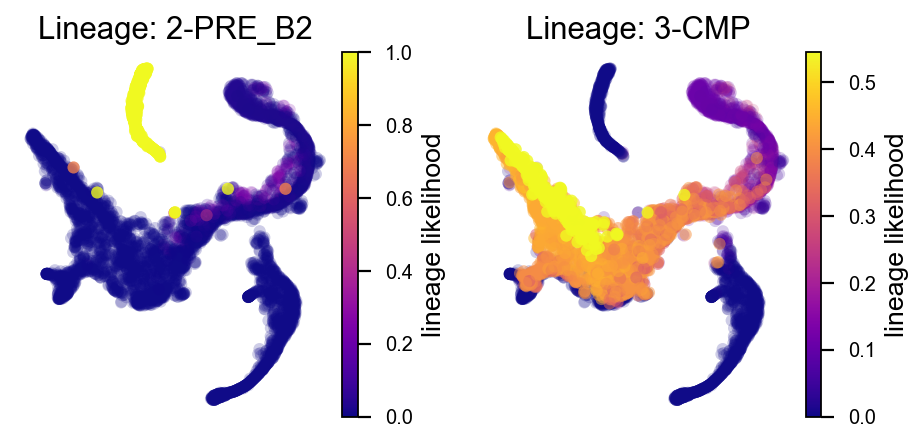

In [11]:
fig,axs=v0.plot_lineage_probability(figsize=(6,3),marker_lineages = [2,3])
fig.savefig('figures/via_fig7.png',dpi=300,bbox_inches = 'tight')

## Gene Dynamics

The gene dynamics along pseudotime for all detected lineages are automatically inferred by VIA. These can be interpreted as the change in gene expression along any given lineage. 

shape of transition matrix raised to power 3 (5780, 5780)


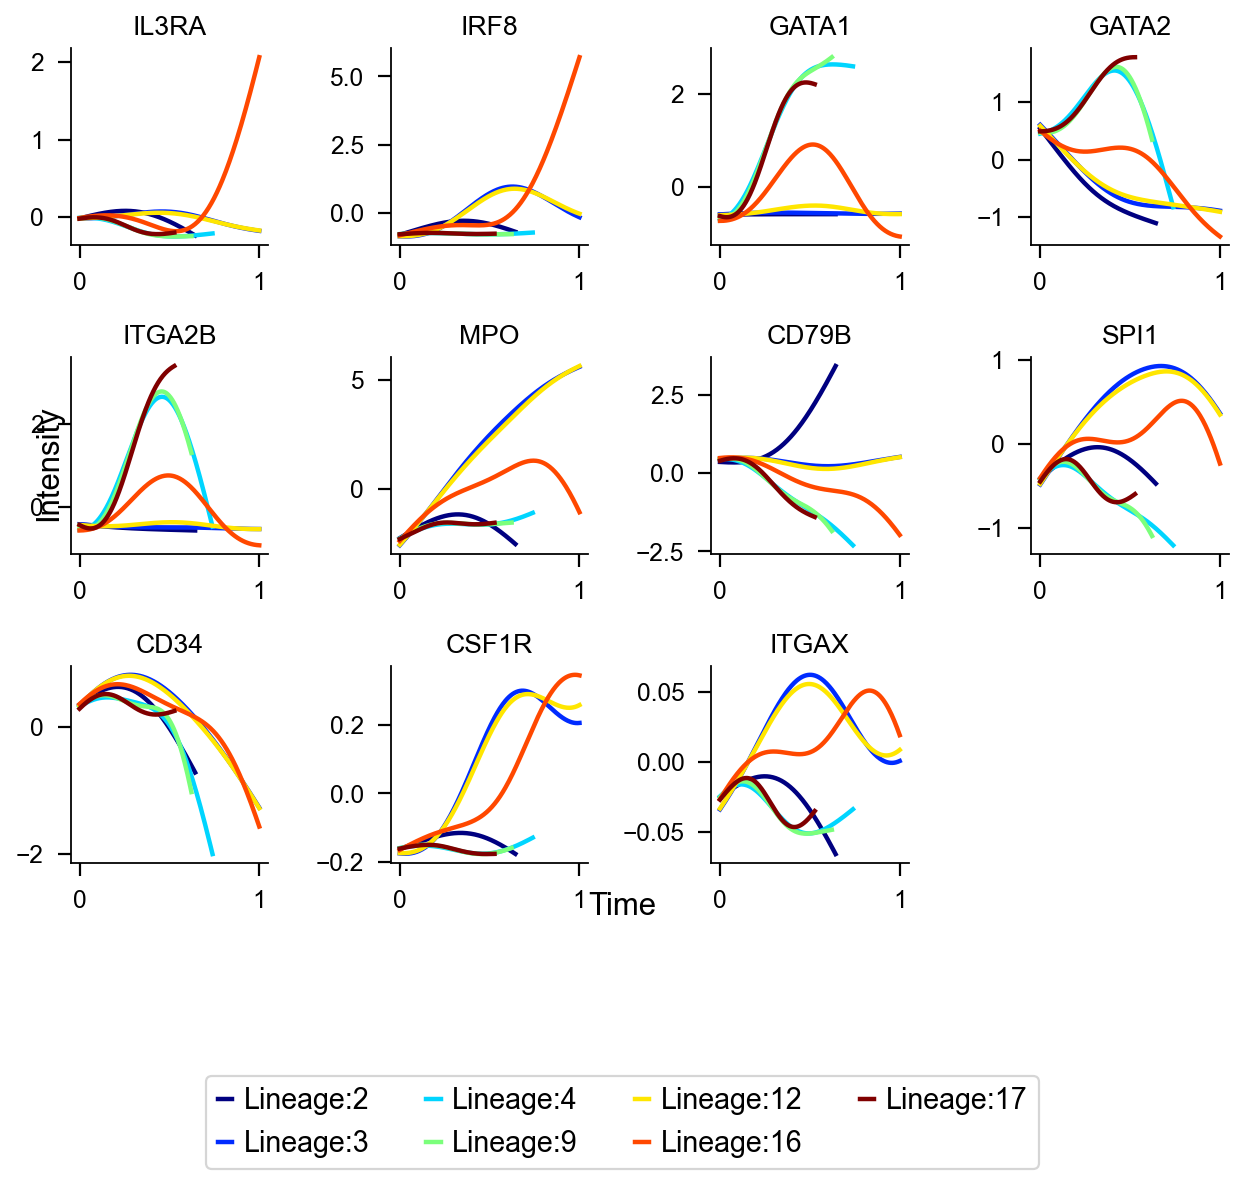

In [12]:
fig,axs=v0.plot_gene_trend(gene_list=gene_list_magic,figsize=(8,6),)
fig.savefig('figures/via_fig8.png',dpi=300,bbox_inches = 'tight')

shape of transition matrix raised to power 3 (5780, 5780)


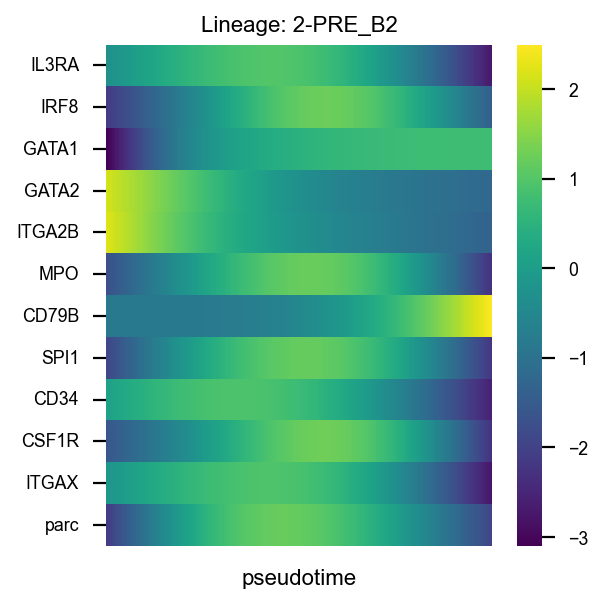

In [14]:
fig,ax=v0.plot_gene_trend_heatmap(gene_list=gene_list_magic,figsize=(4,4),
                          marker_lineages=[2])
fig.savefig('figures/via_fig9.png',dpi=300,bbox_inches = 'tight')